In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import GRU

start = datetime.datetime(2010, 1, 1)                #read Google and apple data
end = datetime.datetime(2019, 1, 1)
dataset = web.DataReader("AAPL", 'yahoo', start, end)
dataset2 = web.DataReader("GOOG", 'yahoo', start, end)
dataset["Close"] = dataset["Close"].replace(',', '').astype(float)
dataset2["Close"] = dataset2["Close"].replace(',', '').astype(float)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
training_set1=dataset['Close']
training_set1=pd.DataFrame(training_set1)

r=0.1
a=int ( len(training_set1)*(1-r))           #make 0.1 of data test set(apple)
b=len(training_set1)
print(a,b,a==b)
training_set=training_set1[0:a]  
text_set=training_set1[a:b]
print(len(text_set))
print(len(training_set))

x=np.array(text_set)                      #save test set with no normalization

2037 2264 False
227
2037


In [3]:
training_set2=dataset2['Close']
training_set2=pd.DataFrame(training_set2)

r=0.1
a=int ( len(training_set2)*(1-r))      #make 0.1 of data test set(google)
b=len(training_set2)
print(a,b,a==b)
training_setX=training_set2[0:a]
text_setX=training_set2[a:b]
print(len(text_setX))
print(len(training_setX))

x1=np.array(text_setX)

2037 2264 False
227
2037


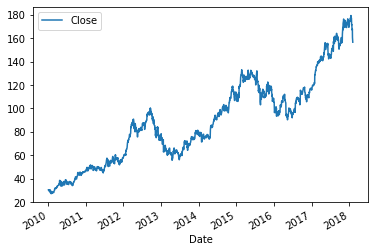

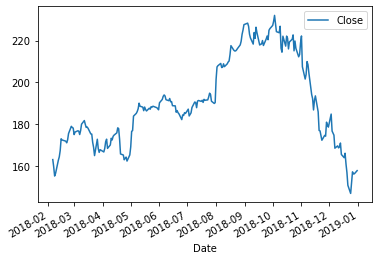

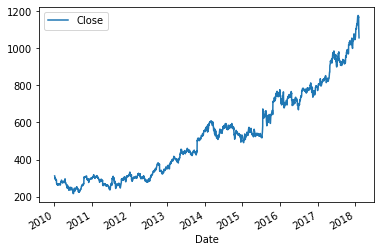

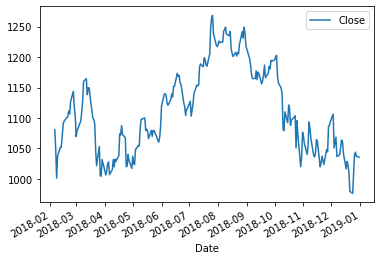

In [4]:
training_set.plot( )
text_set.plot()

training_setX.plot( )
text_setX.plot()

In [5]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))       # Feature Scaling for apple
training_set_scaled = sc.fit_transform(training_set)
text_set_scaled = sc.transform(text_set)

print(len(training_set_scaled))
print(len(training_set))

2037
2037


In [6]:
scX = MinMaxScaler(feature_range = (0, 1))       # Feature Scaling for google
training_set_scaledX = scX.fit_transform(training_setX)
text_set_scaledX = scX.transform(text_setX)

# print(training_set_scaledX)
print(len(training_setX))

2037


In [7]:
X_train = []                                # Creating  train dataset with 30 timesteps and 1 output 
y_train = []
r=0.1
a=int ( len(training_set)*(1-r))
b=len(training_set)
day=30
train=[]
test=[]
for i in range(day, b):                                                   
    train=training_set_scaled[i-day:i, 0]                           #create "data" set from apple data                                           
    train=np.column_stack((train,training_set_scaledX[i-day:i, 0]))#add google data to "data" set
    X_train.append(train)

    test=[]
    test.append(training_set_scaled[i, 0])                          #add apple data to LABELS 
    test.append(training_set_scaledX[i, 0])                          #add google data to LABELS
    y_train.append(test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))


textX = []                                                          # Creating  TEST dataset with 30 timesteps and 1 output 
textY = []
text_y=[]
train=[]
test=[]
a=int ( len(text_set)*(1-r))
b=len(text_set)
for i in range(day, b):                                             
    train=text_set_scaled[i-day:i, 0]                                #create "data" set from apple data 
    train=np.column_stack((train,text_set_scaledX[i-day:i, 0]))      #add google data to "data" set
    textX.append(train)
    test=[]
    test.append(text_set_scaled[i, 0])                               #add apple data to LABELS 
    test.append(text_set_scaledX[i, 0])                              #add google data to LABELS
    text_y.append(test)
    test=[]
    test.append(x[i])                                                #add apple labels with no normalization 
    test.append(x1[i])                                               #add google labels with no normalization 
    textY.append(test)


textX, textY ,text_y = np.array(textX), np.array(textY), np.array(text_y)
textX = np.reshape(textX, (textX.shape[0], textX.shape[1], 2))        # Reshaping

In [8]:
def drawTrainTrend(h):
  plt.plot(h.history['mean_squared_error'], label='mean_squared_error (training data)')
  plt.plot(h.history['val_mean_squared_error'], label='mean_squared_error (test data)')
  # plt.title('train')
  plt.ylabel('mean_squared_error value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  plt.plot(h.history['mean_absolute_percentage_error'], label='mean_absolute_percentage_error (training data)')
  plt.plot(h.history['val_mean_absolute_percentage_error'], label='mean_absolute_percentage_error (test data)')
  # plt.title('train')
  plt.ylabel('mean_absolute_percentage_error value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

In [9]:
def drawTestResults(real_stock_price,predicted_stock_price):
  
  predicted_stock_price1 = sc.inverse_transform(predicted_stock_price) # reverse apple data normalization
  predicted_stock_priceX=scX.inverse_transform(predicted_stock_price) # reverse google data normalization
  predicted_stock_price1=pd.DataFrame(predicted_stock_price1)
  predicted_stock_priceX=pd.DataFrame(predicted_stock_priceX)

  real_stock_price = np.reshape(real_stock_price, (real_stock_price.shape[0], real_stock_price.shape[1]))
  real_stock_price=pd.DataFrame(real_stock_price)

  plt.plot(real_stock_price[1], color = 'red', label = 'Real Google Stock Price')
  plt.plot(predicted_stock_priceX[1], color = 'blue', label = 'Predicted Google Stock Price')
  plt.title('Google Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()

  plt.plot(predicted_stock_price1[0], color = 'blue', label = 'Predicted APPLE Stock Price')
  plt.plot(real_stock_price[0], color = 'red', label = 'Real Google Stock Price')
  plt.title('APPLE Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('APPLE Stock Price')
  plt.legend()
  plt.show()


In [12]:
def test(CellType,hasDrop,costFunction,optimization):  # create a rnn with cellType(GRU,LSTM,simpleRNN) and test
  regressor = Sequential()
  regressor.add(CellType(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))
  if(hasDrop):
    regressor.add(Dropout(0.2))
  regressor.add(CellType(units = 50, return_sequences = True))
  if(hasDrop):
    regressor.add(Dropout(0.2))

  regressor.add(CellType(units = 50, return_sequences = True))
  if(hasDrop):
    regressor.add(Dropout(0.2))

  regressor.add(CellType(units = 50))
  if(hasDrop):
    regressor.add(Dropout(0.2))

  regressor.add(Dense(units = 2))

  regressor.compile(optimizer = optimization, loss = costFunction ,metrics=['accuracy',"mean_squared_error","mean_absolute_percentage_error"])

  start = time.time()

  h=regressor.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data=(textX,text_y),verbose=True) #train
  end = time.time()
  print(end - start)
  drawTrainTrend(h)

  X_test = np.array(textX)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
  predicted_stock_price = regressor.predict(X_test)                                                             #test
  drawTestResults(textY,predicted_stock_price)  


Epoch 1/100
63/63 [==============================] - 5s 81ms/step - loss: 0.0151 - accuracy: 0.7404 - mean_squared_error: 0.0151 - mean_absolute_percentage_error: 13810.7930 - val_loss: 0.0100 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0100 - val_mean_absolute_percentage_error: 7.5148
Epoch 2/100
63/63 [==============================] - 4s 61ms/step - loss: 0.0041 - accuracy: 0.8610 - mean_squared_error: 0.0041 - mean_absolute_percentage_error: 6024.6045 - val_loss: 0.0111 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0111 - val_mean_absolute_percentage_error: 7.9689
Epoch 3/100
63/63 [==============================] - 4s 57ms/step - loss: 0.0035 - accuracy: 0.8724 - mean_squared_error: 0.0035 - mean_absolute_percentage_error: 8014.0352 - val_loss: 0.0090 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0090 - val_mean_absolute_percentage_error: 7.0068
Epoch 4/100
63/63 [==============================] - 4s 66ms/step - loss: 0.0039 - accuracy: 0.8779 - mean_squared_error

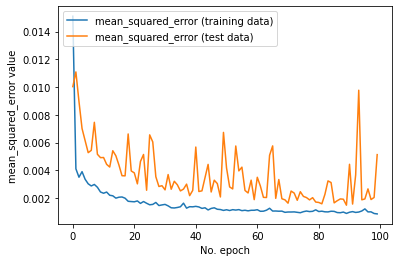

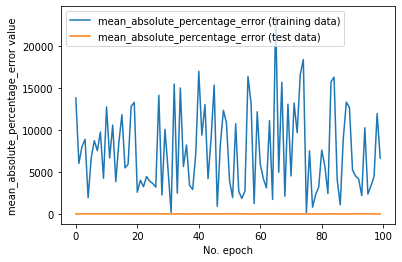

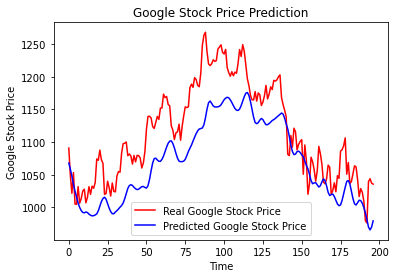

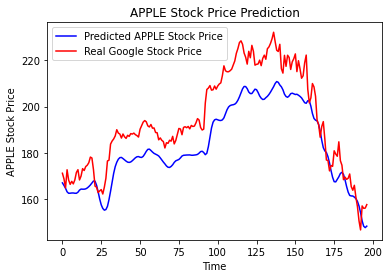

In [13]:
test(LSTM,True,'mean_squared_error','adam')

Epoch 1/100
63/63 [==============================] - 6s 91ms/step - loss: 0.0236 - accuracy: 0.7399 - mean_squared_error: 0.0236 - mean_absolute_percentage_error: 11302.8701 - val_loss: 0.0085 - val_accuracy: 0.9492 - val_mean_squared_error: 0.0085 - val_mean_absolute_percentage_error: 6.5428
Epoch 2/100
63/63 [==============================] - 4s 61ms/step - loss: 0.0052 - accuracy: 0.8426 - mean_squared_error: 0.0052 - mean_absolute_percentage_error: 3023.4062 - val_loss: 0.0046 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0046 - val_mean_absolute_percentage_error: 5.5085
Epoch 3/100
63/63 [==============================] - 4s 62ms/step - loss: 0.0046 - accuracy: 0.8475 - mean_squared_error: 0.0046 - mean_absolute_percentage_error: 7185.0879 - val_loss: 0.0068 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0068 - val_mean_absolute_percentage_error: 6.7839
Epoch 4/100
63/63 [==============================] - 4s 61ms/step - loss: 0.0036 - accuracy: 0.8710 - mean_squared_error

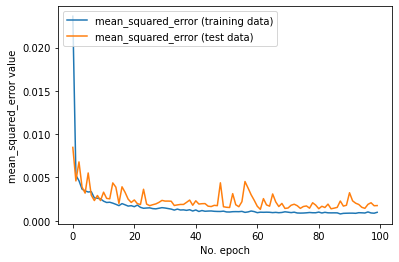

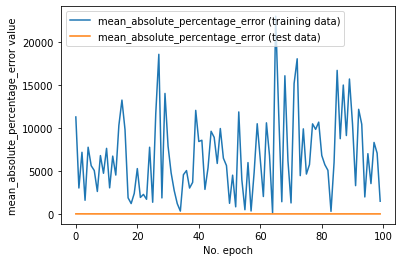

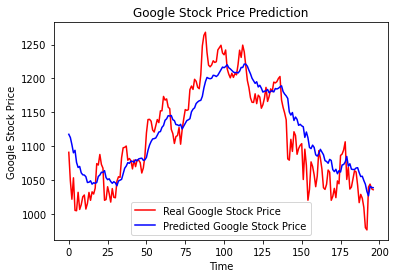

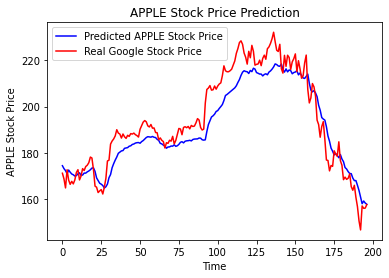

In [14]:
test(GRU,True,'mean_squared_error','adam')

Epoch 1/100
63/63 [==============================] - 3s 41ms/step - loss: 0.3340 - accuracy: 0.5426 - mean_squared_error: 0.3340 - mean_absolute_percentage_error: 86931.7656 - val_loss: 0.0403 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0403 - val_mean_absolute_percentage_error: 16.4813
Epoch 2/100
63/63 [==============================] - 2s 28ms/step - loss: 0.2042 - accuracy: 0.5346 - mean_squared_error: 0.2042 - mean_absolute_percentage_error: 255417.5938 - val_loss: 0.0602 - val_accuracy: 0.2995 - val_mean_squared_error: 0.0602 - val_mean_absolute_percentage_error: 19.5803
Epoch 3/100
63/63 [==============================] - 2s 28ms/step - loss: 0.1274 - accuracy: 0.5571 - mean_squared_error: 0.1274 - mean_absolute_percentage_error: 46382.4570 - val_loss: 0.0093 - val_accuracy: 0.9492 - val_mean_squared_error: 0.0093 - val_mean_absolute_percentage_error: 7.8860
Epoch 4/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0831 - accuracy: 0.5630 - mean_squared_

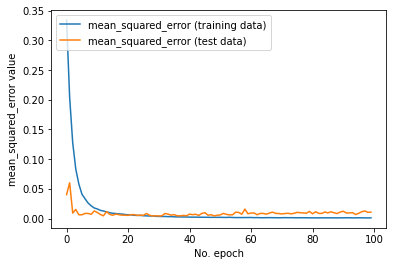

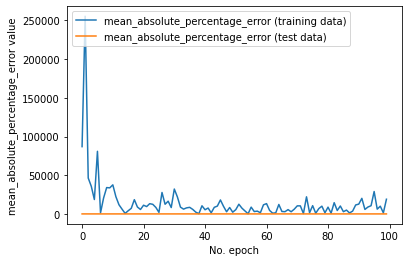

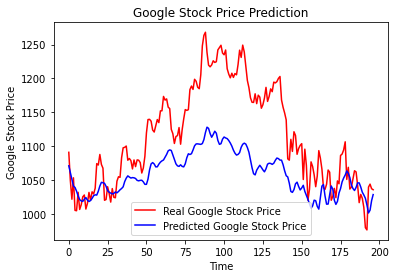

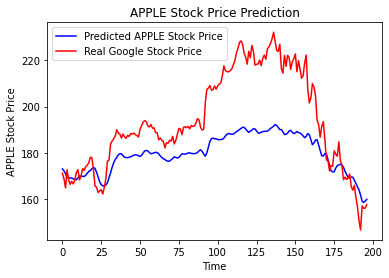

In [15]:
test(SimpleRNN,True,'mean_squared_error','adam')

Epoch 1/100
63/63 [==============================] - 5s 87ms/step - loss: 0.1508 - accuracy: 0.6074 - mean_squared_error: 0.1508 - mean_absolute_percentage_error: 35764.3594 - val_loss: 0.7359 - val_accuracy: 0.9797 - val_mean_squared_error: 0.7359 - val_mean_absolute_percentage_error: 83.3560
Epoch 2/100
63/63 [==============================] - 4s 59ms/step - loss: 0.0800 - accuracy: 0.6452 - mean_squared_error: 0.0800 - mean_absolute_percentage_error: 49073.4141 - val_loss: 0.5195 - val_accuracy: 0.9797 - val_mean_squared_error: 0.5195 - val_mean_absolute_percentage_error: 69.7052
Epoch 3/100
63/63 [==============================] - 4s 59ms/step - loss: 0.0565 - accuracy: 0.6976 - mean_squared_error: 0.0565 - mean_absolute_percentage_error: 65900.1875 - val_loss: 0.3992 - val_accuracy: 0.9797 - val_mean_squared_error: 0.3992 - val_mean_absolute_percentage_error: 60.8734
Epoch 4/100
63/63 [==============================] - 4s 59ms/step - loss: 0.0474 - accuracy: 0.7105 - mean_squared_

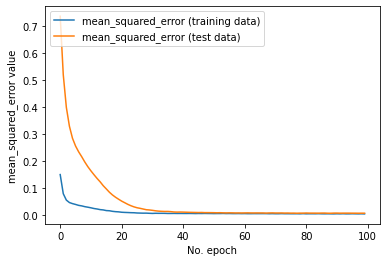

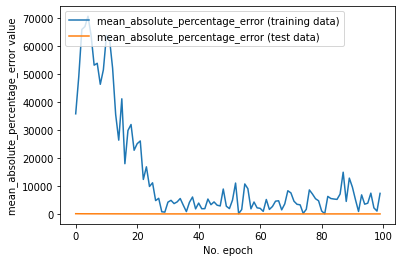

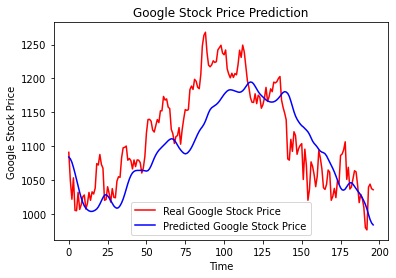

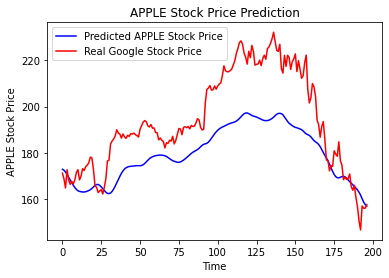

In [16]:
test(GRU,True,'mean_squared_error','Adagrad')

Epoch 1/100
63/63 [==============================] - 6s 91ms/step - loss: 0.0147 - accuracy: 0.7474 - mean_squared_error: 0.0147 - mean_absolute_percentage_error: 1757.6641 - val_loss: 0.0035 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0035 - val_mean_absolute_percentage_error: 4.7843
Epoch 2/100
63/63 [==============================] - 4s 60ms/step - loss: 0.0070 - accuracy: 0.8176 - mean_squared_error: 0.0070 - mean_absolute_percentage_error: 11761.7148 - val_loss: 0.0266 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0266 - val_mean_absolute_percentage_error: 12.6868
Epoch 3/100
63/63 [==============================] - 4s 58ms/step - loss: 0.0058 - accuracy: 0.8316 - mean_squared_error: 0.0058 - mean_absolute_percentage_error: 3674.9097 - val_loss: 0.0043 - val_accuracy: 0.9391 - val_mean_squared_error: 0.0043 - val_mean_absolute_percentage_error: 4.9412
Epoch 4/100
63/63 [==============================] - 4s 61ms/step - loss: 0.0052 - accuracy: 0.8540 - mean_squared_erro

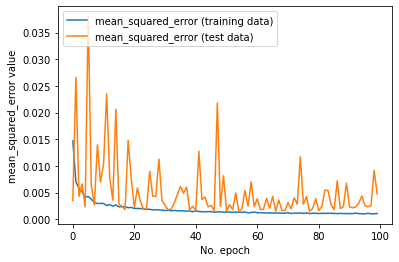

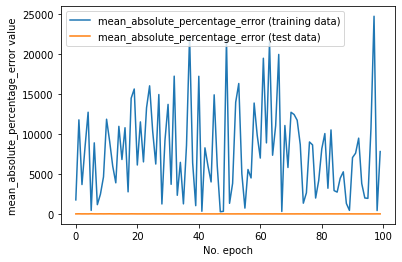

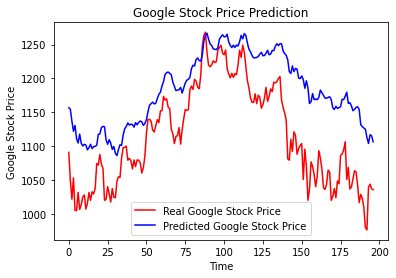

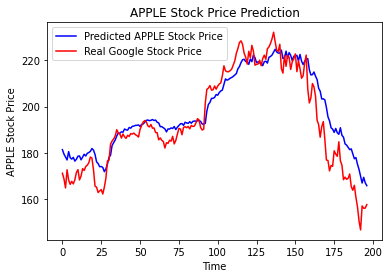

In [17]:
test(GRU,True,'mean_squared_error','RMSprop')

Epoch 1/100
63/63 [==============================] - 5s 77ms/step - loss: 0.0154 - accuracy: 0.7240 - mean_squared_error: 0.0154 - mean_absolute_percentage_error: 7842.1431 - val_loss: 0.0085 - val_accuracy: 0.4924 - val_mean_squared_error: 0.0085 - val_mean_absolute_percentage_error: 7.3985
Epoch 2/100
63/63 [==============================] - 4s 61ms/step - loss: 4.2219e-04 - accuracy: 0.9487 - mean_squared_error: 4.2219e-04 - mean_absolute_percentage_error: 3973.9099 - val_loss: 0.0027 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0027 - val_mean_absolute_percentage_error: 4.0805
Epoch 3/100
63/63 [==============================] - 4s 60ms/step - loss: 3.4616e-04 - accuracy: 0.9557 - mean_squared_error: 3.4616e-04 - mean_absolute_percentage_error: 3640.6719 - val_loss: 0.0019 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0019 - val_mean_absolute_percentage_error: 3.3432
Epoch 4/100
63/63 [==============================] - 4s 59ms/step - loss: 2.7519e-04 - accuracy: 0.9616 -

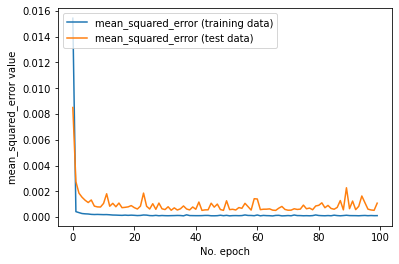

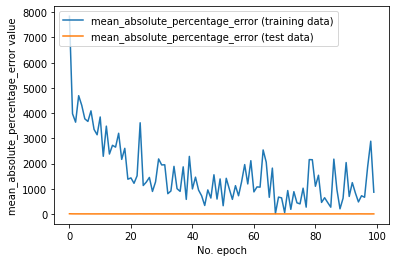

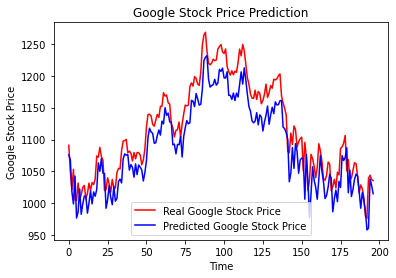

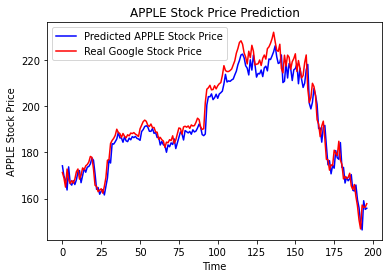

In [18]:
test(GRU,False,'mean_squared_error','adam')

Epoch 1/100
63/63 [==============================] - 5s 81ms/step - loss: 0.1236 - accuracy: 0.7195 - mean_squared_error: 0.1236 - mean_absolute_percentage_error: 15089.2852 - val_loss: 0.6005 - val_accuracy: 0.9797 - val_mean_squared_error: 0.6005 - val_mean_absolute_percentage_error: 75.7716
Epoch 2/100
63/63 [==============================] - 4s 58ms/step - loss: 0.0641 - accuracy: 0.7713 - mean_squared_error: 0.0641 - mean_absolute_percentage_error: 36116.6914 - val_loss: 0.4191 - val_accuracy: 0.9797 - val_mean_squared_error: 0.4191 - val_mean_absolute_percentage_error: 63.1834
Epoch 3/100
63/63 [==============================] - 4s 66ms/step - loss: 0.0468 - accuracy: 0.7713 - mean_squared_error: 0.0468 - mean_absolute_percentage_error: 43140.9609 - val_loss: 0.3271 - val_accuracy: 0.9797 - val_mean_squared_error: 0.3271 - val_mean_absolute_percentage_error: 55.6100
Epoch 4/100
63/63 [==============================] - 4s 58ms/step - loss: 0.0395 - accuracy: 0.7713 - mean_squared_

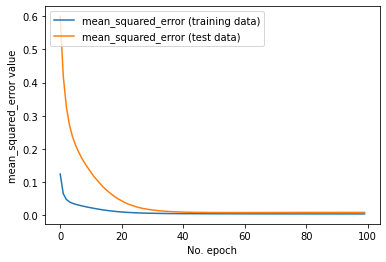

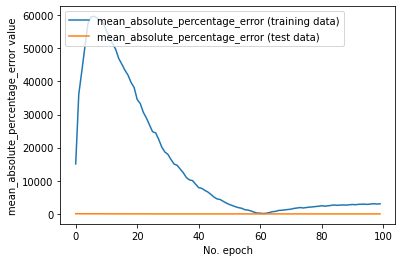

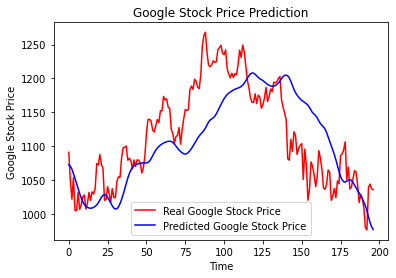

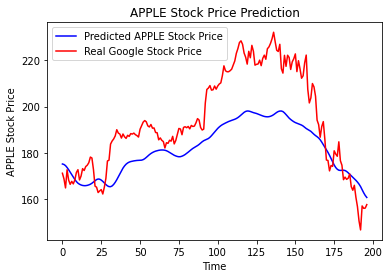

In [19]:
test(GRU,False,'mean_squared_error','Adagrad')

Epoch 1/100
63/63 [==============================] - 5s 79ms/step - loss: 0.0122 - accuracy: 0.7972 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 558.4216 - val_loss: 0.0105 - val_accuracy: 0.9391 - val_mean_squared_error: 0.0105 - val_mean_absolute_percentage_error: 8.0265
Epoch 2/100
63/63 [==============================] - 4s 67ms/step - loss: 0.0031 - accuracy: 0.8774 - mean_squared_error: 0.0031 - mean_absolute_percentage_error: 3383.6819 - val_loss: 0.0021 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0021 - val_mean_absolute_percentage_error: 3.4516
Epoch 3/100
63/63 [==============================] - 4s 69ms/step - loss: 0.0022 - accuracy: 0.8874 - mean_squared_error: 0.0022 - mean_absolute_percentage_error: 4058.9548 - val_loss: 0.0033 - val_accuracy: 0.9797 - val_mean_squared_error: 0.0033 - val_mean_absolute_percentage_error: 4.8621
Epoch 4/100
63/63 [==============================] - 4s 58ms/step - loss: 0.0021 - accuracy: 0.8819 - mean_squared_error: 

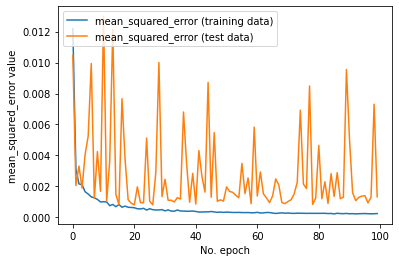

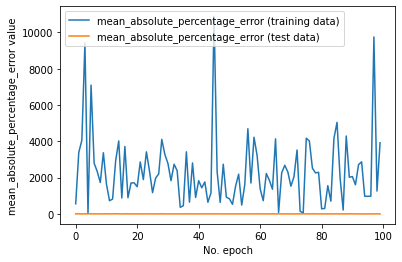

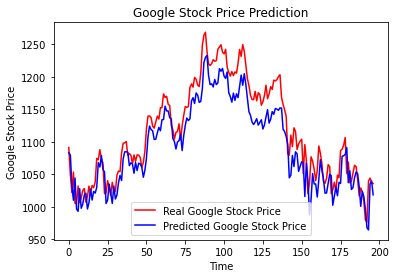

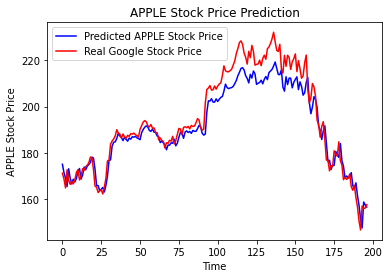

In [20]:
test(GRU,False,'mean_squared_error','RMSprop')

Epoch 1/100
63/63 [==============================] - 5s 79ms/step - loss: 6847.9316 - accuracy: 0.7314 - mean_squared_error: 0.0924 - mean_absolute_percentage_error: 6847.9316 - val_loss: 73.9411 - val_accuracy: 0.9797 - val_mean_squared_error: 0.6640 - val_mean_absolute_percentage_error: 73.9411
Epoch 2/100
63/63 [==============================] - 4s 62ms/step - loss: 23344.2773 - accuracy: 0.7105 - mean_squared_error: 0.0662 - mean_absolute_percentage_error: 23344.2773 - val_loss: 43.2485 - val_accuracy: 0.9797 - val_mean_squared_error: 0.2531 - val_mean_absolute_percentage_error: 43.2485
Epoch 3/100
63/63 [==============================] - 4s 63ms/step - loss: 29615.9902 - accuracy: 0.6936 - mean_squared_error: 0.0536 - mean_absolute_percentage_error: 29615.9902 - val_loss: 62.9373 - val_accuracy: 0.9797 - val_mean_squared_error: 0.5040 - val_mean_absolute_percentage_error: 62.9373
Epoch 4/100
63/63 [==============================] - 4s 63ms/step - loss: 25078.3574 - accuracy: 0.558

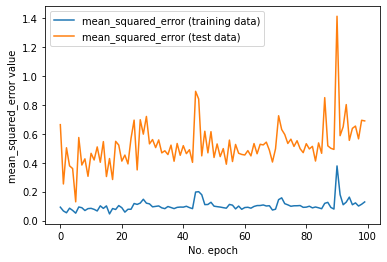

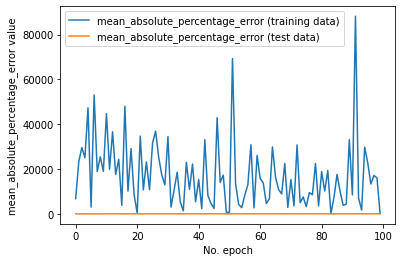

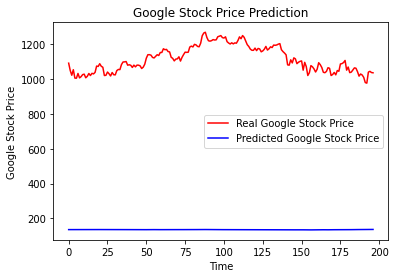

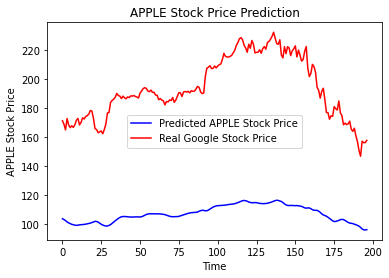

In [ ]:
test(GRU,True,'mean_absolute_percentage_error','adam')